<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import (train_test_split, 
                                     TimeSeriesSplit, 
                                     GridSearchCV)
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import time
import warnings

In [2]:
# загрузка данных
# индексы в виде дат
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.info()
df.sample(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-06-12 11:40:00,20
2018-05-15 21:40:00,16
2018-03-15 06:50:00,1


In [3]:
# статистика целевого признака
display(df.describe())
print('Соблюдается ли хронологический порядок данных:', df.index.is_monotonic)
print('Временной интервал данных:', df.index.min(), '-', df.index.max())

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Соблюдается ли хронологический порядок данных: True
Временной интервал данных: 2018-03-01 00:00:00 - 2018-08-31 23:50:00


In [4]:
# ресемплируем данные по одному часу
df = df.resample("1H").sum()

* `26496` строк;
* Пропуски: отсутствуют;
* Соблюдается хронологический порядок данных;
* Периодичность данных: `10` минут.

## Анализ

In [5]:
# столбцы с плавающим средним и стандартным отклонением
# график временного ряда
df_mean = df.copy()
df_mean['rolling_mean'] = df_mean['num_orders'].shift().rolling(60).mean()
df_mean['rolling_std'] = df_mean['num_orders'].shift().rolling(60).std()

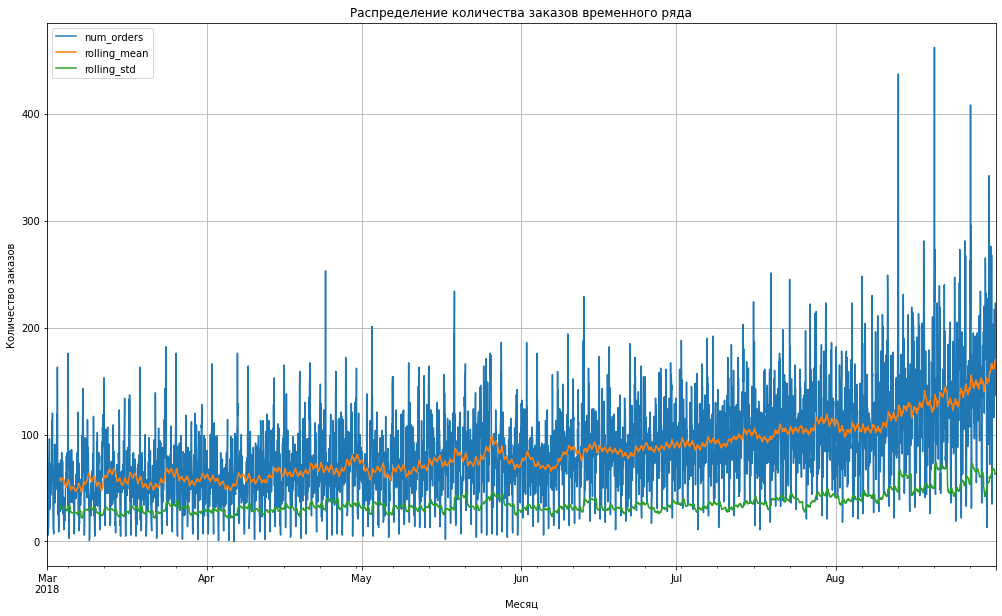

In [6]:
df_mean.plot(figsize=(17, 10),
        title='Распределение количества заказов временного ряда',
        xlabel='Месяц',
        ylabel='Количество заказов',
        grid=True);

Проверим временной ряд на стационарность:    
* Нулевая гипотеза: ряд имеет единичный корень, ряд не стационарен;
* Альтернативная гипотеза: ряд не имеет единичного корня, ряд стационарен.

In [16]:
# тест Дикки-Фуллера на стационарность временного ряда
result = adfuller(df['num_orders'], autolag='AIC')

print('Критерий ADF: %f' % result[0])

print('P-значение: %f' % result[1])

print('Критические значения:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    if result[0] < result[4][key]:
        print ("Нулевая гипотеза отвергнута: временной ряд стационарен")
    else:
        print ("Нулевая гипотеза подтверждена: временной ряд не стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
Нулевая гипотеза подтверждена: временной ряд не стационарен
	5%: -2.862
Нулевая гипотеза отвергнута: временной ряд стационарен
	10%: -2.567
Нулевая гипотеза отвергнута: временной ряд стационарен


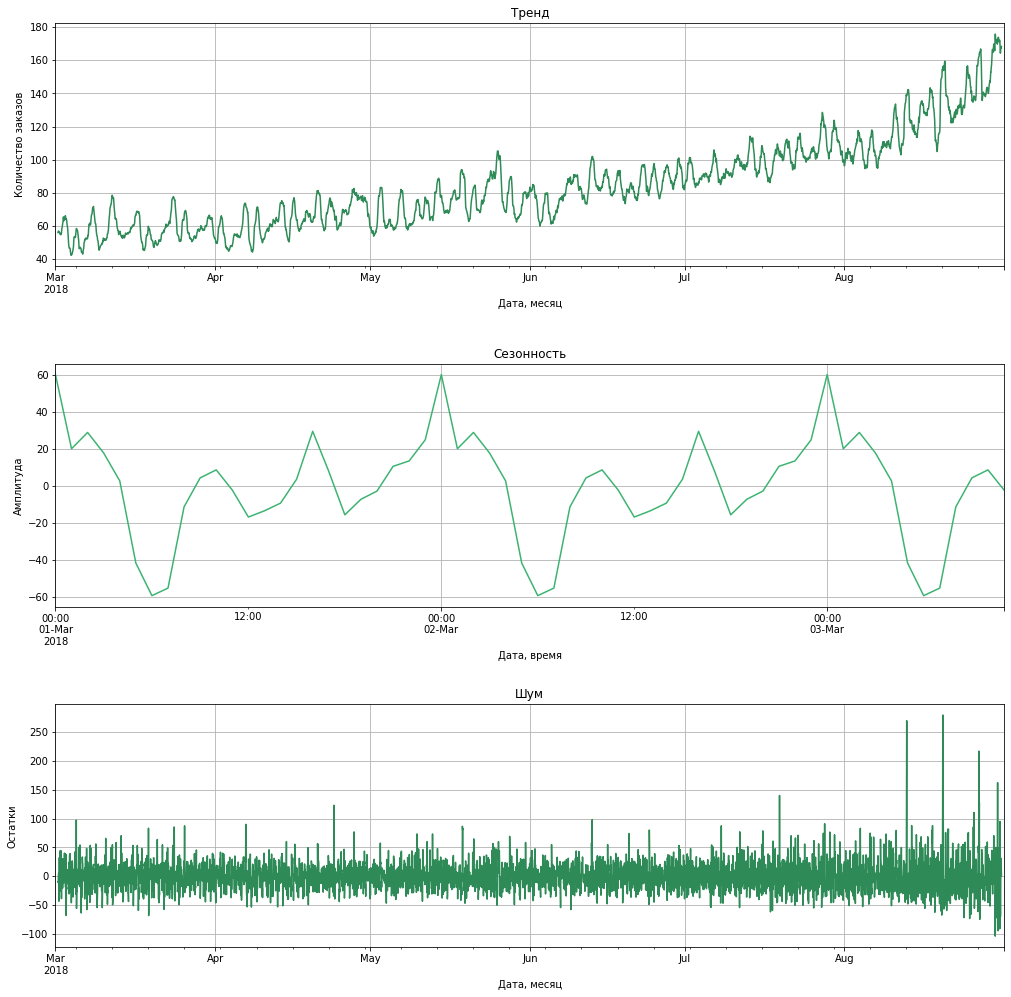

In [20]:
# тренды и сезонность
decomposed = seasonal_decompose(df)
fig, ax = plt.subplots(3, 1, figsize=(17, 17))
plt.subplots_adjust(hspace=0.4)

decomposed.trend.plot(ax=ax[0], title='Тренд', xlabel='Дата, месяц',
                      ylabel='Количество заказов', grid=True, color='seagreen')
decomposed.seasonal.head(60).plot(ax=ax[1], title='Сезонность', xlabel='Дата, время',
                                  ylabel='Амплитуда', grid=True, color='mediumseagreen')
decomposed.resid.plot(ax=ax[2], title='Шум', xlabel='Дата, месяц', ylabel='Остатки', grid=True, color='seagreen')
plt.show()

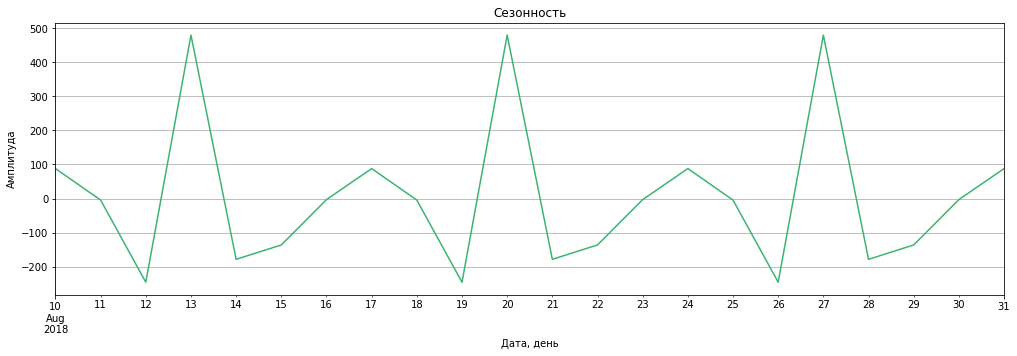

In [9]:
# сезонность за неделю (период: 10.08.18 - 31.08.18)
df_week = df.resample("1D").sum()

decomposed_week = seasonal_decompose(df_week['2018-08-10':'2018-08-31'])

plt.figure(figsize=(17,5))
decomposed_week.seasonal.plot(title='Сезонность', xlabel='Дата, день', ylabel='Амплитуда',
                              grid=True, color='mediumseagreen')
plt.show()

* Временной ряд нестационарен на `1%` уровне значимости.
* Данные имеют восходящий тренд количества заказов от марта до августа;
* Сезонность в сутки: меньше всего заказов утром, больше всего ночью (`00:00`), есть два меньших всплеска до полудня и после (утром и днём можно пользоваться общественным транспортом, ночью который обычно не работает. Так же, утром чаще могут прилетать люди по рабочим вопросам и быть мене склонным к заказам такси, чем туристы, менее ограниченные по времени);
* Сезонность по неделям: 
* * максимум в понедельник и пятницу,
* * минимум во вторник и воскресенье.

* Данные ресемплированы суммированием по одному часу.


## Обучение

In [29]:
# создадим новые признаки: день, час, отстающие значения, скользящее среднее
def make_features(df, max_lag, roll):
    df_make_features = df.copy()
    df_make_features['dayofweek']=df_make_features.index.dayofweek
    df_make_features['hour']=df_make_features.index.hour
    for i in range(1,max_lag+1):
        df_make_features['lag_{}'.format(i)]=df_make_features['num_orders'].shift(i)
    df_make_features['rolling_mean']=df_make_features['num_orders'].shift().rolling(roll).mean()
    return df_make_features.dropna()

In [30]:
df_mf = make_features(df, 24, 100)
df_mf.sample(3)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-06-01 01:00:00,77,4,1,118.0,129.0,93.0,107.0,75.0,62.0,36.0,...,91.0,71.0,17.0,6.0,48.0,142.0,92.0,101.0,61.0,76.55
2018-07-16 04:00:00,187,0,4,136.0,126.0,109.0,224.0,100.0,98.0,85.0,...,108.0,62.0,61.0,92.0,73.0,36.0,48.0,74.0,96.0,101.44
2018-07-16 07:00:00,82,0,7,15.0,64.0,187.0,136.0,126.0,109.0,224.0,...,106.0,116.0,73.0,108.0,62.0,61.0,92.0,73.0,36.0,100.29


In [35]:
# обучающая и тестовая выборки: 9:1
random_state = 42
X = df_mf.drop('num_orders', axis=1)
y = df_mf['num_orders']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1, random_state=random_state)
print('Обучающая:', X_train.shape)
print('Тестовая:', X_test.shape)

Обучающая: (3884, 27)
Тестовая: (432, 27)


In [1]:
# обучим три модели: LGBMRegressor, RandomForestRegressor, CatBoostRegressor
# метрика rmse
lgbm_params = {'n_estimators': [90, 180, 310],
               'max_depth': [7, 14, 20],
               'num_leaves': [8, 15, 30],
               'learning_rate': [0.1, 0.5]}

rf_params = {'n_estimators': [20, 90, 170],
             'max_depth': [5, 15, 30],
             'max_features': [3, 7, 13]}

catboost_params = {'learning_rate': [0.1, 0.5],
                   'iterations': [25, 90, 210],
                   'max_depth': [3, 10, 16]}

In [38]:
best_scores = {}

tscv = TimeSeriesSplit (n_splits = 5)

models = {"LightGBM": LGBMRegressor(random_state=random_state),
          "Random Forest": RandomForestRegressor(random_state=random_state),
          "CatBoost": CatBoostRegressor(random_state=random_state)}


for model_name, model in models.items():
    if model_name == "LightGBM":
        param_grid = lgbm_params
    elif model_name == "Random Forest":
        param_grid = rf_params
    else:
        param_grid = catboost_params

    grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_root_mean_squared_error')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_

    best_scores[model_name] = best_score

print()
for model_name, best_score in best_scores.items():
    print(f"{model_name}: Score = {-best_score:.4f}, Params = {best_params}")



0:	learn: 27.9504970	total: 47.9ms	remaining: 1.15s
1:	learn: 27.1854395	total: 48.9ms	remaining: 563ms
2:	learn: 26.3054421	total: 49.8ms	remaining: 365ms
3:	learn: 25.5205811	total: 50.7ms	remaining: 266ms
4:	learn: 24.7678285	total: 51.5ms	remaining: 206ms
5:	learn: 24.1063947	total: 52.3ms	remaining: 165ms
6:	learn: 23.4491534	total: 53ms	remaining: 136ms
7:	learn: 22.9865910	total: 53.9ms	remaining: 114ms
8:	learn: 22.4196844	total: 54.6ms	remaining: 97.1ms
9:	learn: 22.0614383	total: 55.5ms	remaining: 83.2ms
10:	learn: 21.7063109	total: 56.4ms	remaining: 71.8ms
11:	learn: 21.3514150	total: 57.2ms	remaining: 61.9ms
12:	learn: 21.0986774	total: 58ms	remaining: 53.5ms
13:	learn: 20.7614618	total: 58.9ms	remaining: 46.3ms
14:	learn: 20.4405815	total: 59.7ms	remaining: 39.8ms
15:	learn: 20.2272828	total: 60.5ms	remaining: 34ms
16:	learn: 20.0544856	total: 61.3ms	remaining: 28.9ms
17:	learn: 19.7987848	total: 62.2ms	remaining: 24.2ms
18:	learn: 19.6789664	total: 63ms	remaining: 19.9m

Лучшая модель: `CatBoost: Score = 25.1740, Params = {'iterations': 210, 'learning_rate': 0.1, 'max_depth': 3}` .

## Тестирование

In [39]:
# проверим модель на тестовой выборке
results = []
predictions_valid = best_model.predict(X_test)
rmse =  np.sqrt(mean_squared_error(y_test, predictions_valid))
results.append({'Модель': model.__class__.__name__,
                'RMSE': rmse})
pd.DataFrame(results)

,Модель,RMSE
0,CatBoostRegressor,44.155534


In [42]:
# проверим модель на адекватность, на модели DummyRegressor, генерирующей константы

dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)
dummy_predictions = dummy_model.predict(X_test)
print(f'RMSE DummyRegressor (mean): {mean_squared_error(y_test, dummy_predictions, squared=False)}')

RMSE DummyRegressor (mean): 84.80942472748956


Модель адекватна, её значения метрики значительно лучше модели, предсказывающей на основе среднего.

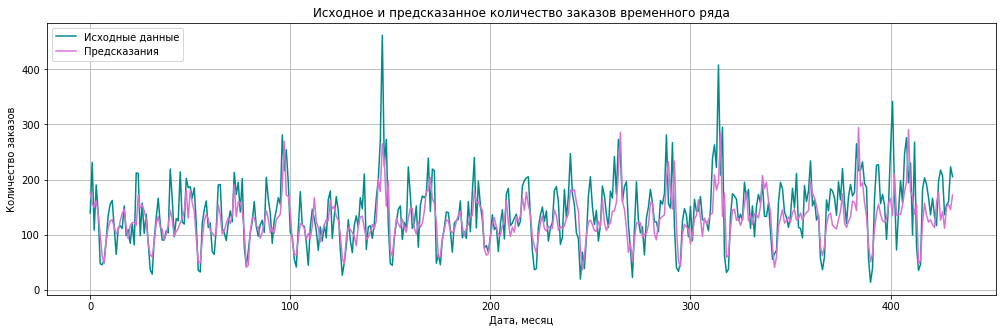

In [44]:
# предсказания и исходные данные
plt.figure(figsize=(17, 5))
plt.plot(y_test.values, 'darkcyan', label="Исходные данные")
plt.plot(predictions_valid, 'orchid', label="Предсказания")
plt.title('Исходное и предсказанное количество заказов временного ряда')
plt.xlabel('Дата, месяц')
plt.ylabel('Количество заказов')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

Модель, в целом, справляется с предсказаниями успешно, поставленную цель выполняет. Есть недостатки на экстремальных значения, что можно пытаться улучшить при необходимости.

**Вывод:**

* Загруженны и проанализированны исторические данные о заказах такси в аэропортах.
* Выполнено ресэмплирование данных с градацией по часу с применением функции суммирования;
* Тест Дикки-Фуллера показал нестационарность временного ряда на `1%` уровне значимости;
* Обнаружен восходящий тренд количества заказов от марта до августа;
* Наблюдается суточная и недельная сезонность: 
* * меньше всего заказов утром, больше всего ночью,
* * минимум во вторник и воскресенье, максимум в понедельник и пятницу.
* Из трёх обученных моделей выбрана наилучшая: `CatBoostRegressor`, модель проверена на адекватность.
* На тестовых данных, значение метрики `RMSE = 44.155534`, что удовлетворяет условиям поставленной задачи.
